## 🔹 GASA - Genetic Algorithm with Simulated Annealing


In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tracemalloc
import random
import math

from typing import List, Tuple

SEED = 42  
random.seed(SEED)
np.random.seed(SEED)


class GASA_mTSP:
    def __init__(self, distance_matrix: np.ndarray, m: int = 3,
                 pop_size: int = 100, generations: int = 300,
                 pc: float = 0.8, pm: float = 0.1,
                 sa_T0: float = 100, sa_alpha: float = 0.95, sa_Tmin: float = 1e-3):
        
        self.distance_matrix = distance_matrix
        self.n_cities = len(distance_matrix)
        self.m = m
        self.pop_size = pop_size
        self.generations = generations
        self.pc = pc
        self.pm = pm
        self.depot = 0

        # SA parameters
        self.sa_T0 = sa_T0
        self.sa_alpha = sa_alpha
        self.sa_Tmin = sa_Tmin

    # ---------------- Step 1: Initialization ----------------
    def initialize_population(self) -> List[List[int]]:
        cities = list(range(1, self.n_cities))
        return [random.sample(cities, len(cities)) for _ in range(self.pop_size)]

    # ---------------- Decode chromosome into m routes ----------------
    def decode_solution(self, chromosome: List[int]) -> List[List[int]]:
        routes = [[] for _ in range(self.m)]
        for i, city in enumerate(chromosome):
            routes[i % self.m].append(city)
        return routes

    # ---------------- Step 2: Fitness ----------------
    def calculate_fitness(self, chromosome: List[int]) -> float:
        routes = self.decode_solution(chromosome)
        route_distances = [
            sum(self.distance_matrix[route[i]][route[i+1]] for i in range(len(route)-1))
            if len(route) > 1 else 0
            for route in [[self.depot] + r + [self.depot] for r in routes]
        ]
        return max(route_distances) if route_distances else float('inf')

    # ---------------- Step 3A: Selection (Roulette Wheel) ----------------
    def tournament_selection(self, population: List[List[int]], fitness: List[float]) -> List[int]:
        total_fitness = sum(1.0 / (f + 1e-6) for f in fitness)
        pick = random.uniform(0, total_fitness)
        current = 0
        for ind, fit in zip(population, fitness):
            current += 1.0 / (fit + 1e-6)
            if current >= pick:
                return ind.copy()
        return population[-1].copy()

    # ---------------- Step 3B: Order-based Crossover (OX) ----------------
    def partially_mapped_crossover(self, p1: List[int], p2: List[int]) -> Tuple[List[int], List[int]]:
        if random.random() > self.pc:
            return p1.copy(), p2.copy()
        size = len(p1)
        start, end = sorted(random.sample(range(size), 2))
        
        def ox(parent1, parent2):
            child = [None] * size
            child[start:end] = parent1[start:end]
            pos = end
            for city in parent2[end:] + parent2[:end]:
                if city not in child:
                    if pos >= size:
                        pos = 0
                    child[pos] = city
                    pos += 1
            return child
        
        return ox(p1, p2), ox(p2, p1)

    # ---------------- Step 3C: Scramble Mutation ----------------
    def index_mutation(self, chromosome: List[int]) -> List[int]:
        if random.random() < self.pm:
            start, end = sorted(random.sample(range(len(chromosome)), 2))
            subset = chromosome[start:end]
            random.shuffle(subset)
            chromosome[start:end] = subset
        return chromosome

    # ---------------- Step 4: Simulated Annealing (SA) ----------------
    def simulated_annealing(self, chromosome: List[int]) -> List[int]:
        current = chromosome.copy()
        current_fit = self.calculate_fitness(current)
        T = self.sa_T0

        while T > self.sa_Tmin:
            # Neighbor by swapping two cities
            neighbor = current.copy()
            i, j = sorted(random.sample(range(len(neighbor)), 2))
            neighbor[i], neighbor[j] = neighbor[j], neighbor[i]
            neighbor_fit = self.calculate_fitness(neighbor)

            # Accept if better or with probability exp(-Δ/T)
            if neighbor_fit < current_fit or random.random() < math.exp(-(neighbor_fit - current_fit) / T):
                current, current_fit = neighbor, neighbor_fit

            T *= self.sa_alpha
        
        return current

    # ---------------- Step 5: Main Loop ----------------
    def run(self):
        population = self.initialize_population()
        best_solution = None
        best_fitness = float('inf')
        fitness_history = []

        for gen in range(self.generations):
            fitness_scores = [self.calculate_fitness(ind) for ind in population]
            sorted_idx = np.argsort(fitness_scores)
            population = [population[i] for i in sorted_idx]
            fitness_scores = [fitness_scores[i] for i in sorted_idx]

            if fitness_scores[0] < best_fitness:
                best_fitness = fitness_scores[0]
                best_solution = population[0].copy()

            # GA: Selection + Crossover + Mutation
            new_population = []
            elite = population[0].copy()
            new_population.append(elite)

            while len(new_population) < self.pop_size:
                p1 = self.tournament_selection(population, fitness_scores)
                p2 = self.tournament_selection(population, fitness_scores)
                c1, c2 = self.partially_mapped_crossover(p1, p2)
                c1 = self.index_mutation(c1)
                c2 = self.index_mutation(c2)
                new_population.extend([c1, c2])

            population = new_population[:self.pop_size]

            # SA on the best individual
            sa_solution = self.simulated_annealing(population[0])
            sa_fitness = self.calculate_fitness(sa_solution)
            if sa_fitness < self.calculate_fitness(population[0]):
                population[0] = sa_solution

            fitness_history.append(best_fitness)

            if gen % 20 == 0:
                print(f"Gen {gen}: Best max route length = {best_fitness:.2f}")

        routes = self.decode_solution(best_solution)
        route_distances = [
            sum(self.distance_matrix[r[i]][r[i+1]] for i in range(len(r)-1))
            for r in [[self.depot] + route + [self.depot] for route in routes]
        ]
        total_distance = sum(route_distances)
        balance_metric = max(route_distances) - min(route_distances) if route_distances else 0

        return routes, total_distance, best_fitness, balance_metric, fitness_history

In [2]:
try:
    distance_df = pd.read_csv('../data/HN_distance_matrix.csv', index_col=0)
    distance_matrix = distance_df.values
    print("Loaded real distance matrix")
except:
    # Fallback to example matrix
    n_cities = 127
    rng = np.random.default_rng(42)
    distance_matrix = rng.uniform(10, 100, size=(n_cities, n_cities))
    distance_matrix = (distance_matrix + distance_matrix.T) / 2
    np.fill_diagonal(distance_matrix, 0)
    print("Using example distance matrix")

print("Số thành phố:", distance_matrix.shape[0])
print("Ví dụ khoảng cách [0][1]:", distance_matrix[0][1])

Loaded real distance matrix
Số thành phố: 127
Ví dụ khoảng cách [0][1]: 21.48


In [3]:
def detect_convergence(fitness_list, window=5, threshold=1e-3):
    """Detect convergence in fitness evolution"""
    if len(fitness_list) < window:
        return len(fitness_list)
    for i in range(len(fitness_list) - window):
        if abs(fitness_list[i] - fitness_list[i + window]) < threshold:
            return i + window
    return len(fitness_list)


========== GASA - Số người (m) = 1 | Chạy 20 lần ==========
Gen 0: Best max route length = 1649.13
Gen 20: Best max route length = 1107.13
Gen 40: Best max route length = 1100.49
Gen 60: Best max route length = 1099.87
Gen 80: Best max route length = 1089.64
Gen 100: Best max route length = 1089.64
Gen 120: Best max route length = 1089.64
Gen 140: Best max route length = 1082.97
Gen 160: Best max route length = 1082.97
Gen 180: Best max route length = 1082.97
Gen 200: Best max route length = 1044.16
Gen 220: Best max route length = 1044.16
Gen 240: Best max route length = 1044.16
Gen 260: Best max route length = 1044.16
Gen 280: Best max route length = 1044.16
 -> Trial 1/20: Fitness=1044.16, Time=15.27sGen 0: Best max route length = 1578.34
Gen 20: Best max route length = 1060.55
Gen 40: Best max route length = 1060.55
Gen 60: Best max route length = 1060.55
Gen 80: Best max route length = 1060.55
Gen 100: Best max route length = 1047.98
Gen 120: Best max route length = 981.77
Gen 14

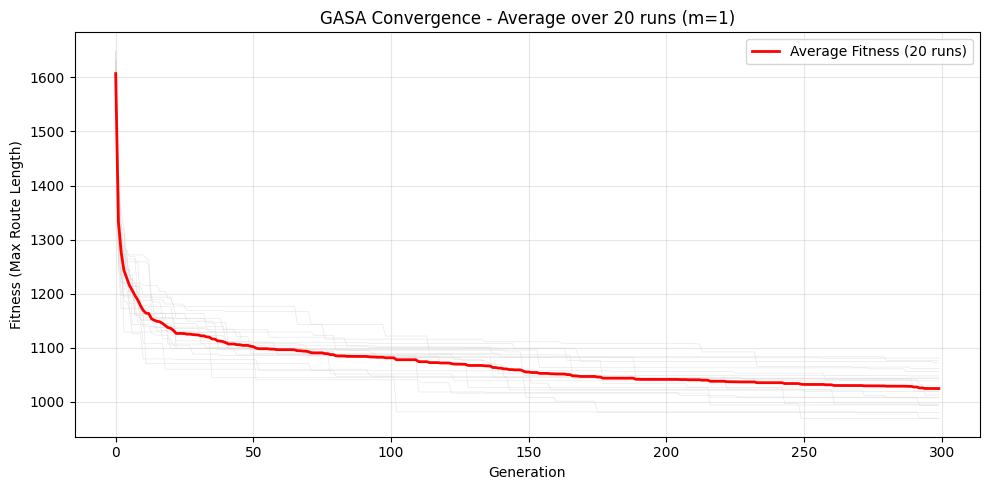


========== GASA - Số người (m) = 2 | Chạy 20 lần ==========
Gen 0: Best max route length = 859.90
Gen 20: Best max route length = 656.18
Gen 40: Best max route length = 621.38
Gen 60: Best max route length = 621.38
Gen 80: Best max route length = 621.38
Gen 100: Best max route length = 621.38
Gen 120: Best max route length = 621.38
Gen 140: Best max route length = 610.73
Gen 160: Best max route length = 601.28
Gen 180: Best max route length = 601.28
Gen 200: Best max route length = 601.28
Gen 220: Best max route length = 601.28
Gen 240: Best max route length = 601.28
Gen 260: Best max route length = 601.28
Gen 280: Best max route length = 596.25
 -> Trial 1/20: Fitness=591.14, Time=10.80sGen 0: Best max route length = 842.87
Gen 20: Best max route length = 693.23
Gen 40: Best max route length = 637.48
Gen 60: Best max route length = 634.30
Gen 80: Best max route length = 625.76
Gen 100: Best max route length = 623.62
Gen 120: Best max route length = 623.62
Gen 140: Best max route leng

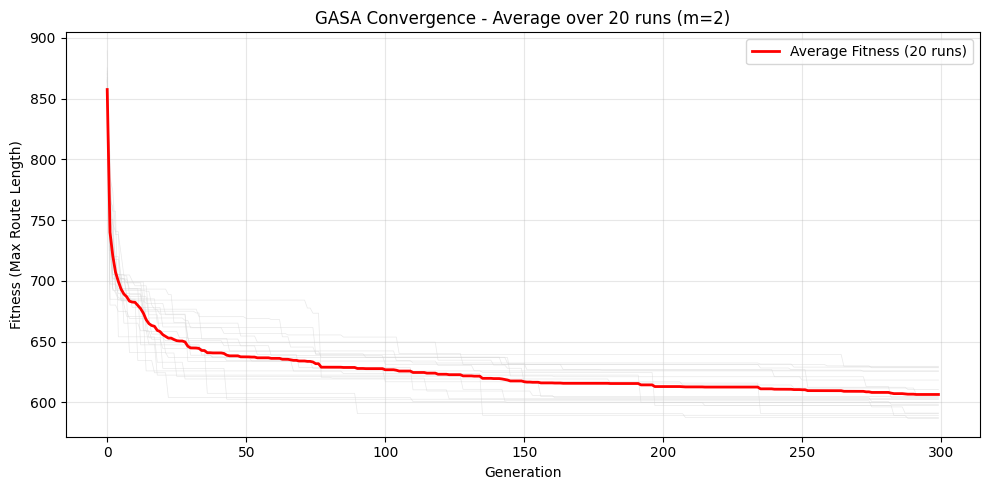


========== GASA - Số người (m) = 3 | Chạy 20 lần ==========
Gen 0: Best max route length = 610.70
Gen 20: Best max route length = 486.26
Gen 40: Best max route length = 469.87
Gen 60: Best max route length = 469.87
Gen 80: Best max route length = 469.87
Gen 100: Best max route length = 455.02
Gen 120: Best max route length = 455.02
Gen 140: Best max route length = 455.02
Gen 160: Best max route length = 448.72
Gen 180: Best max route length = 448.72
Gen 200: Best max route length = 448.72
Gen 220: Best max route length = 448.72
Gen 240: Best max route length = 448.72
Gen 260: Best max route length = 448.72
Gen 280: Best max route length = 448.72
 -> Trial 1/20: Fitness=448.72, Time=11.96sGen 0: Best max route length = 565.01
Gen 20: Best max route length = 494.37
Gen 40: Best max route length = 494.37
Gen 60: Best max route length = 467.80
Gen 80: Best max route length = 461.36
Gen 100: Best max route length = 455.99
Gen 120: Best max route length = 455.99
Gen 140: Best max route leng

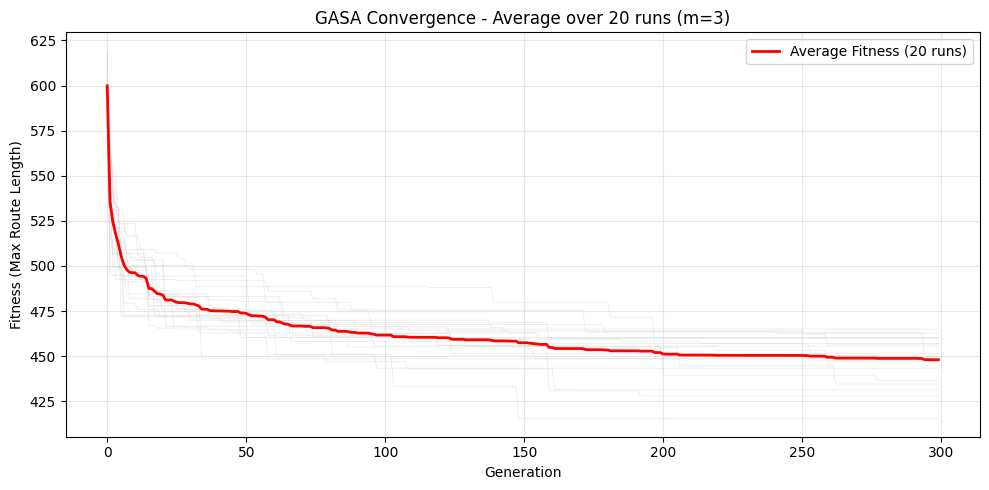


=== HOÀN TẤT THỰC NGHIỆM GASA ===


In [4]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

# --- CẤU HÌNH ---
N_TRIALS = 20  # Số lần chạy cho mỗi m
m_values = range(1, 4) # Số người bán hàng từ 1 đến 3

# Tên file lưu trữ
detail_file = "results_details_gasa.csv"    # Lưu từng lần chạy (để kiểm tra)
stats_file = "results_summary_gasa.csv"     # Lưu thống kê (Mean ± Std)

# Các cột dữ liệu cần theo dõi
metrics = [
    "total_distance", "fitness", "balance_metric", 
    "exec_time", "converged_gen", "convergence_speed"
]

# 1. Khởi tạo file chi tiết (xóa cũ tạo mới)
pd.DataFrame(columns=["m", "trial"] + metrics).to_csv(detail_file, index=False)

# 2. Khởi tạo file thống kê (xóa cũ tạo mới)
stats_cols = ["m"] + [f"{col}_mean" for col in metrics] + [f"{col}_std" for col in metrics]
pd.DataFrame(columns=stats_cols).to_csv(stats_file, index=False)

# --- VÒNG LẶP CHÍNH ---
for m in m_values:
    print(f"\n{'='*10} GASA - Số người (m) = {m} | Chạy {N_TRIALS} lần {'='*10}")
    
    trial_results = []       # Lưu kết quả các chỉ số của 20 lần
    all_fitness_history = [] # Lưu lịch sử fitness để vẽ biểu đồ

    for trial in range(1, N_TRIALS + 1):
        # --- Bắt đầu đo lường ---
        start_time = time.time()
        
        # Gọi thuật toán GASA
        # Lưu ý: Đảm bảo class GASA_mTSP đã được định nghĩa trước đó
        gasa = GASA_mTSP(distance_matrix, m=m, pop_size=100, generations=300)
        routes, total_distance, max_route, balance_metric, fitness_per_generation = gasa.run()
        
        end_time = time.time()
        exec_time = end_time - start_time

        # --- Tính toán lại khoảng cách chi tiết (giữ nguyên logic của bạn) ---
        route_distances = []
        for route in routes:
            if len(route) > 0:
                full_route = [0] + route + [0]
                distance = sum(distance_matrix[full_route[i]][full_route[i+1]] 
                               for i in range(len(full_route)-1))
                route_distances.append(distance)
            else:
                route_distances.append(0)

        # Tính lại balance_metric chính xác từ route_distances thực tế
        balance_metric = max(route_distances) - min(route_distances) if route_distances else 0

        # Phân tích hội tụ
        converged_gen = detect_convergence(fitness_per_generation)
        convergence_speed = (fitness_per_generation[0] - fitness_per_generation[-1]) / converged_gen if converged_gen > 0 else 0

        # --- Lưu kết quả lần chạy này ---
        row = {
            "m": m,
            "trial": trial,
            "total_distance": total_distance,
            "fitness": max_route, # max_route chính là fitness trong bài toán MinMax
            "balance_metric": balance_metric,
            "exec_time": exec_time,
            "converged_gen": converged_gen,
            "convergence_speed": convergence_speed
        }
        trial_results.append(row)
        all_fitness_history.append(fitness_per_generation)

        # Ghi ngay vào file detail
        pd.DataFrame([row]).to_csv(detail_file, mode="a", index=False, header=False)
        
        # In tiến độ gọn gàng (không in full route để tránh rối màn hình)
        print(f"\r -> Trial {trial}/{N_TRIALS}: Fitness={max_route:.2f}, Time={exec_time:.2f}s", end="")

    print(f"\n   [Hoàn thành {N_TRIALS} lần chạy cho m={m}]")

    # --- TÍNH TOÁN THỐNG KÊ (MEAN & STD) ---
    df_trials = pd.DataFrame(trial_results)
    stats_row = {"m": m}
    
    for col in metrics:
        stats_row[f"{col}_mean"] = df_trials[col].mean()
        stats_row[f"{col}_std"] = df_trials[col].std()
    
    # Lưu file tổng hợp
    pd.DataFrame([stats_row]).to_csv(stats_file, mode="a", index=False, header=False)

    # Hiển thị báo cáo nhanh
    print(f"   => Trung bình Fitness (Max Route): {stats_row['fitness_mean']:.2f} (±{stats_row['fitness_std']:.2f})")
    print(f"   => Trung bình Balance: {stats_row['balance_metric_mean']:.2f}")
    print(f"   => Trung bình Thời gian: {stats_row['exec_time_mean']:.4f}s")

    # --- VẼ BIỂU ĐỒ FITNESS TRUNG BÌNH ---
    # Xử lý đệm dữ liệu (Padding) nếu số thế hệ khác nhau (phòng hờ early stopping)
    max_len = max(len(h) for h in all_fitness_history)
    padded_history = []
    for h in all_fitness_history:
        padded = h + [h[-1]] * (max_len - len(h))
        padded_history.append(padded)
    
    avg_fitness_curve = np.mean(padded_history, axis=0)

    plt.figure(figsize=(10, 5))
    # Vẽ các đường mờ (từng lần chạy)
    for h in all_fitness_history:
        plt.plot(h, color='lightgray', alpha=0.5, linewidth=0.5)
    # Vẽ đường trung bình
    plt.plot(avg_fitness_curve, color='red', linewidth=2, label='Average Fitness (20 runs)')
    
    plt.title(f"GASA Convergence - Average over {N_TRIALS} runs (m={m})")
    plt.xlabel("Generation")
    plt.ylabel("Fitness (Max Route Length)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

print("\n=== HOÀN TẤT THỰC NGHIỆM GASA ===")

end


=== GASA - Số người bán hàng (m) = 1 ===
Gen 0: Best max route length = 1649.13
Gen 20: Best max route length = 1107.13
Gen 40: Best max route length = 1100.49
Gen 60: Best max route length = 1099.87
Gen 80: Best max route length = 1089.64
Gen 100: Best max route length = 1089.64
Gen 120: Best max route length = 1089.64
Gen 140: Best max route length = 1082.97
Gen 160: Best max route length = 1082.97
Gen 180: Best max route length = 1081.30
Gen 200: Best max route length = 1069.33
Gen 220: Best max route length = 1069.33
Gen 240: Best max route length = 995.67
Gen 260: Best max route length = 994.20
Gen 280: Best max route length = 994.20
Tổng quãng đường: 994.20
Chiều dài route dài nhất (Max route length): 994.20
Chênh lệch giữa các route (Balance metric): 0.00
Thời gian thực thi: 11.9713 giây
Số vòng lặp cần thiết để hội tụ: 8
Tốc độ hội tụ: 81.8662 đơn vị/gen
 - Tuyến 1 (994.20): [0, 57, 28, 114, 117, 121, 116, 108, 35, 65, 76, 80, 62, 15, 30, 122, 123, 38, 119, 118, 25, 5, 107, 74

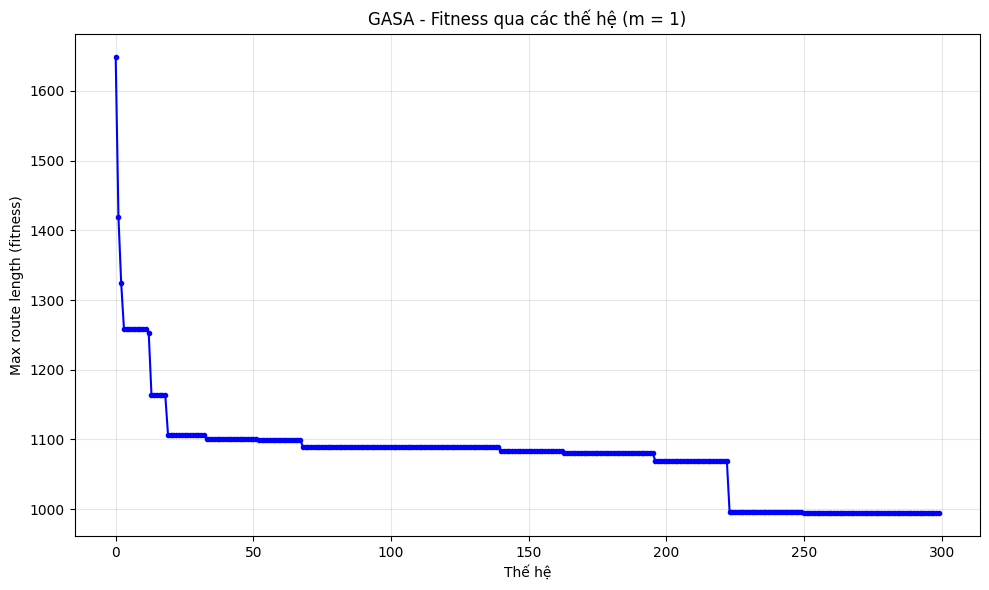


=== GASA - Số người bán hàng (m) = 2 ===
Gen 0: Best max route length = 832.28
Gen 20: Best max route length = 675.50
Gen 40: Best max route length = 661.21
Gen 60: Best max route length = 645.12
Gen 80: Best max route length = 633.38
Gen 100: Best max route length = 633.38
Gen 120: Best max route length = 633.38
Gen 140: Best max route length = 633.38
Gen 160: Best max route length = 633.38
Gen 180: Best max route length = 633.38
Gen 200: Best max route length = 633.38
Gen 220: Best max route length = 633.38
Gen 240: Best max route length = 633.38
Gen 260: Best max route length = 633.38
Gen 280: Best max route length = 633.38
Tổng quãng đường: 1265.05
Chiều dài route dài nhất (Max route length): 633.38
Chênh lệch giữa các route (Balance metric): 1.71
Thời gian thực thi: 13.0498 giây
Số vòng lặp cần thiết để hội tụ: 10
Tốc độ hội tụ: 19.8900 đơn vị/gen
 - Tuyến 1 (633.38): [0, 49, 54, 69, 88, 64, 107, 13, 86, 27, 18, 67, 42, 2, 6, 19, 73, 46, 43, 84, 40, 126, 104, 36, 65, 14, 76, 32, 

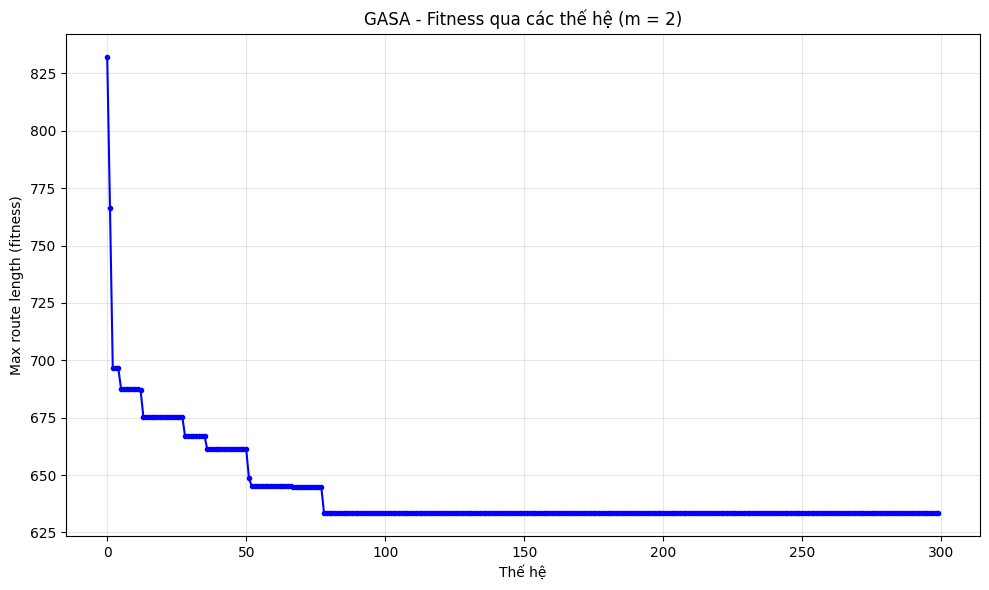


=== GASA - Số người bán hàng (m) = 3 ===
Gen 0: Best max route length = 614.00
Gen 20: Best max route length = 454.75
Gen 40: Best max route length = 450.61
Gen 60: Best max route length = 450.61
Gen 80: Best max route length = 450.61
Gen 100: Best max route length = 450.61
Gen 120: Best max route length = 450.61
Gen 140: Best max route length = 450.61
Gen 160: Best max route length = 450.61
Gen 180: Best max route length = 450.61
Gen 200: Best max route length = 450.31
Gen 220: Best max route length = 450.31
Gen 240: Best max route length = 450.24
Gen 260: Best max route length = 450.18
Gen 280: Best max route length = 450.18
Tổng quãng đường: 1339.67
Chiều dài route dài nhất (Max route length): 450.18
Chênh lệch giữa các route (Balance metric): 5.57
Thời gian thực thi: 13.0036 giây
Số vòng lặp cần thiết để hội tụ: 23
Tốc độ hội tụ: 7.1226 đơn vị/gen
 - Tuyến 1 (444.88): [0, 91, 102, 27, 3, 49, 59, 105, 28, 109, 107, 126, 95, 9, 1, 88, 61, 63, 74, 87, 93, 18, 32, 70, 16, 62, 69, 14, 

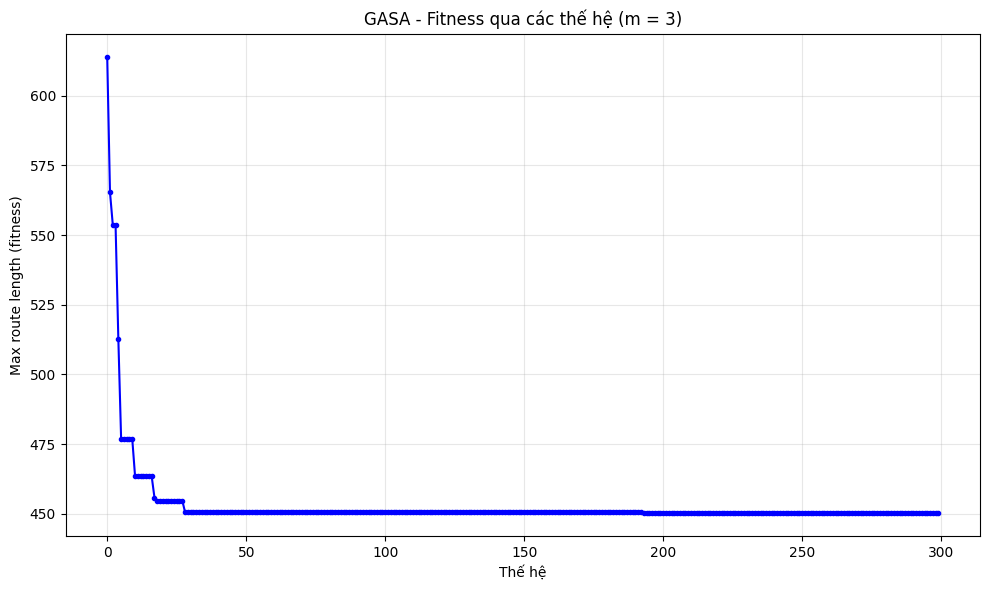

In [ ]:
# File tổng hợp kết quả
summary_file = "results_summary_gasa.csv"
summary_cols = [
    "m", "total_distance", "fitness", "balance_metric",
    "exec_time", "converged_gen", "convergence_speed"
]

# Run experiments for different numbers of salesmen
for m in range(1, 4):
    print(f"\n=== GASA - Số người bán hàng (m) = {m} ===")

    start_time = time.time()

    gasa = GASA_mTSP(distance_matrix, m=m, pop_size=100, generations=300)
    routes, total_distance, max_route, balance_metric, fitness_per_generation = gasa.run()

    end_time = time.time()
    exec_time = end_time - start_time

    # Tính khoảng cách từng route
    route_distances = []
    for route in routes:
        if len(route) > 0:
            full_route = [0] + route + [0]
            distance = sum(distance_matrix[full_route[i]][full_route[i+1]] 
                           for i in range(len(full_route)-1))
            route_distances.append(distance)
        else:
            route_distances.append(0)

    # Chênh lệch giữa các route
    balance_metric = max(route_distances) - min(route_distances) if route_distances else 0

    # Phân tích hội tụ
    converged_gen = detect_convergence(fitness_per_generation)
    convergence_speed = (fitness_per_generation[0] - fitness_per_generation[-1]) / converged_gen if converged_gen > 0 else 0

    # In kết quả
    print(f"Tổng quãng đường: {total_distance:.2f}")
    print(f"Chiều dài route dài nhất (Max route length): {max_route:.2f}")
    print(f"Chênh lệch giữa các route (Balance metric): {balance_metric:.2f}")
    print(f"Thời gian thực thi: {exec_time:.4f} giây")
    print(f"Số vòng lặp cần thiết để hội tụ: {converged_gen}")
    print(f"Tốc độ hội tụ: {convergence_speed:.4f} đơn vị/gen")

    # Hiển thị từng route
    for i, route in enumerate(routes):
        if len(route) > 0:
            full_route = [0] + route + [0]
            print(f" - Tuyến {i+1} ({route_distances[i]:.2f}): {full_route}")
        else:
            print(f" - Tuyến {i+1} (0.00): [0]")

    # === Lưu file tổng hợp ===
    row = {
        "m": m,
        "total_distance": total_distance,
        "fitness": max_route,
        "balance_metric": balance_metric,
        "exec_time": exec_time,
        "converged_gen": converged_gen,
        "convergence_speed": convergence_speed
    }
    pd.DataFrame([row]).to_csv(summary_file, mode="a", index=False, header=False)

    # === Lưu fitness_per_generation riêng ===
    fitness_file = f"gasa_fitness_m{m}.csv"
    pd.DataFrame({
        "generation": range(len(fitness_per_generation)),
        "fitness": fitness_per_generation
    }).to_csv(fitness_file, index=False)

    # Vẽ biểu đồ fitness
    plt.figure(figsize=(10, 6))
    plt.plot(fitness_per_generation, marker='o', linestyle='-', color='blue', markersize=3)
    plt.title(f"GASA - Fitness qua các thế hệ (m = {m})")
    plt.xlabel("Thaế hệ")
    plt.ylabel("Max route length (fitness)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
